In [1]:
import pandas as pd
import polars as pl
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
import json
import numpy as np
import pickle
from datetime import datetime
from scipy.stats import spearmanr,pearsonr,kendalltau,pointbiserialr
DATA_ROOT = '/media/gustavo/Storage/Datasets/Onion20k'
DATA_ROOT_URL=Path(DATA_ROOT)
sns.set_theme()


In [4]:
full_feat_tracks=pd.read_csv(DATA_ROOT_URL/'emotions_familiarity_full_feat_stack.tsv',sep='\t')

In [70]:
full_feat_tracks.describe()

,row_id,score,lfm_id,year,month,day
count,40541.000000,40541.000000,40541.000000,40541.000000,40541.000000,40541.000000
mean,12103.503071,0.407982,12103.503071,2000.439604,4.760341,10.339853
std,7067.862191,0.314764,7067.862191,11.713701,3.701689,9.861750
min,1.000000,0.005780,1.000000,1900.000000,1.000000,1.000000
25%,5948.000000,0.151515,5948.000000,1996.000000,1.000000,1.000000
50%,12072.000000,0.333333,12072.000000,2004.000000,4.000000,7.000000
75%,18186.000000,0.571429,18186.000000,2008.000000,8.000000,19.000000
max,24407.000000,1.000000,24407.000000,2021.000000,12.000000,31.000000


In [11]:
full_feat_tracks['gem_label'].value_counts()

transcendence        7549
joyful activation    6081
nostalgia            5507
power                5198
wonder               5093
peacefulness         4221
sadness              4155
tension              1639
tenderness           1094
Name: gem_label, dtype: int64

In [12]:
gems_groups = full_feat_tracks.groupby('gem_label')['lfm_id'].apply(lambda x: list(x))
gems_to_lfm_tracks= gems_groups.to_dict()

In [66]:
import polars as pl
def calculate_pop(data):
    # Generating item popularity  (Abdollahpouri'17) (Kowald'22)  Pop_i = |U_i|/|U| 
    unique_users= data.select(["user_id"]).collect()['user_id'].n_unique()
    item_popularity = data.groupby(["track_id"]).agg(
    [
        (pl.col('user_id').n_unique()/unique_users).alias("pop_i"), 
        pl.count().alias("track_playcount")
    ]
    ).sort('pop_i',reverse=True).collect()
    return item_popularity

def calculate_familiarity(data,R=3):
    # Generating item popularity  (Abdollahpouri'17) (Kowald'22)  Pop_i = |U_i|/|U| 
    unique_users= data.select(["user_id"]).collect()['user_id'].n_unique()
    item_familiarity = data.groupby(["track_id","user_id"]).agg(
    [   
        pl.count().alias("user_track_playcount")
    ]
    ).filter(
        pl.col("user_track_playcount")>=R
        ).groupby(["track_id"]).agg(
        pl.col("user_id").n_unique().alias("num_fam_users")).with_column(
        (pl.col("num_fam_users")/unique_users).alias("fam_i")).sort('fam_i',reverse=True).collect()
    return item_familiarity

def get_ur_timeframe(data, offset='1mo'):
    return (
        data.with_column((pl.col("timestamp").min().dt.offset_by(offset).alias("ts_ref")).over(
        pl.col([ "track_id","user_id"])
    )).with_column((pl.col("ts_ref") - pl.col("timestamp")).dt.timestamp().alias("ts_diff")
    ).filter(pl.col("ts_diff")>0)
    )
def get_ss_timeframe(data,release_dates,offset='1mo'):
    release_dates_data = data.join(release_dates,left_on='track_id',right_on='lfm_id',how='inner')
    return release_dates_data.with_column((pl.col("release_data").first().dt.offset_by(offset).alias("ts_ref")).over(
        pl.col([ "track_id","user_id"])
    )).with_column((pl.col("ts_ref") - pl.col("timestamp")).dt.timestamp().alias("ts_diff")
    ).filter(pl.col("ts_diff")>0)
    
def calculate_tpop(data,offset,):
    
    unique_users= data.select(["user_id"]).collect()['user_id'].n_unique()
    item_popularity = data.pipe(get_ur_timeframe,offset=)
    .groupby(["track_id"]).agg(
    [
        (pl.col('user_id').n_unique()/unique_users).alias("pop_i"), 
        pl.count().alias("track_playcount")
    ]
    ).sort('t_pop_i',reverse=True).collect()
    return item_popularity



In [54]:
def calculate_bll_score_global(data, decay=0.5):
    return (
        data.with_column((pl.col("timestamp").max().dt.offset_by('1h').alias("ts_ref")).over(
        pl.col([ "user_id"])
    )).with_column((pl.col("ts_ref") - pl.col("timestamp")).dt.timestamp().alias("ts_diff")
).filter(pl.col("ts_diff")>0).groupby(['track_id','user_id']).agg([pl.col('ts_diff').pow(-decay).sum().log().alias("bll_score")]).groupby('track_id').agg(pl.col("bll_score").mean()))

def calculate_bll_score(data, offset="2w1h",decay=0.5):
    return (
        data.with_column((pl.col("timestamp").min().dt.offset_by(offset).alias("ts_ref")).over(
        pl.col(["track_id", "user_id"])
    )).with_column((pl.col("ts_ref") - pl.col("timestamp")).dt.timestamp().alias("ts_diff")
).filter(pl.col("ts_diff")>0).groupby(['track_id','user_id']).agg([(pl.col('ts_diff').pow(-decay).sum()).log().alias("bll_score")]).groupby('track_id').agg(pl.col("bll_score").mean()))

def calculate_bll_score_min_freq(data, offset="2w1h",decay=0.5,R=3):
    return (
        data.with_column((pl.col("timestamp").min().dt.offset_by(offset).alias("ts_ref")).over(
        pl.col(["track_id", "user_id"])
    )).with_column((pl.col("ts_ref") - pl.col("timestamp")).dt.timestamp().alias("ts_diff")
).filter((pl.col("ts_diff")>0)).groupby(['track_id','user_id']).agg([(pl.col('ts_diff').pow(-decay).sum()).log().alias("bll_score"),pl.col('ts_diff').count().alias('count')]).filter(pl.col('count')>=R).groupby('track_id').agg(pl.col("bll_score").mean()))

# Calculating popularity measures

In [88]:
data = pl.scan_csv(DATA_ROOT_URL/'user_item_timestamp.tsv',sep='\t').rename(mapping={"track_index":"track_id","time":"timestamp"})

In [144]:
!wc -l {DATA_ROOT_URL}/user_item_timestamp.tsv

230884331 /media/gustavo/Storage/Datasets/Onion20k/user_item_timestamp.tsv


In [151]:
data.select([pl.col('user_id').n_unique().alias("unique_users"),pl.col('track_id').n_unique().alias("unique_tracks")]).collect()


unique_users,unique_tracks
u32,u32
118934,24402


In [50]:
data.filter(pl.col('track_id').is_in(pl.lit(merged_data['lfm_id'].unique()))).select(pl.col('user_id').n_unique()).collect()

user_id
u32
118289


In [4]:
itempop_all=calculate_pop(data)

In [6]:
itempop_all.write_csv(DATA_ROOT_URL/'track_all_popularity.csv')

In [22]:
itemfam_all = calculate_familiarity(data,R=20)

In [23]:
itemfam_all.write_csv(DATA_ROOT_URL/'track_all_familiarity.csv')

In [17]:
itemfam5_all = calculate_familiarity(data,R=5)
itemfam5_all.write_csv(DATA_ROOT_URL/'track_all_familiarity5.csv')

In [55]:
offset="1mo"
decay=0.5
min_freq=3
data = pl.scan_csv(DATA_ROOT_URL/'user_item_timestamp.tsv',sep='\t',parse_dates=True).rename(mapping={"track_index":"track_id","time":"timestamp"})
data.pipe(calculate_bll_score,offset=offset,decay=decay).collect().write_csv(DATA_ROOT_URL/f"bll_scores_{offset}.csv")
data.pipe(calculate_bll_score_min_freq,offset=offset,decay=decay,R=min_freq).collect().write_csv(DATA_ROOT_URL/f"bll_scores_minfreq_{offset}.csv")
#data.pipe(calculate_bll_score_global,decay=decay).collect().write_csv(DATA_ROOT_URL/f"bll_scores_global.csv")

In [2]:
offset="4y"
decay=0.5
min_freq=3
data = pl.scan_csv(DATA_ROOT_URL/'user_item_timestamp.tsv',sep='\t',parse_dates=True).rename(mapping={"track_index":"track_id","time":"timestamp"})
bll_item_scores= data.with_column((pl.col("timestamp").max().dt.offset_by(offset).alias("ts_ref")).over(
        pl.col([ "user_id"])
    )).with_column((pl.col("ts_ref") - pl.col("timestamp")).dt.timestamp().alias("ts_diff")
).filter(pl.col("ts_diff")>0).groupby(['track_id','user_id']).agg([pl.col('ts_diff').pow(-decay).sum().log().alias("bll_score")]).sort('user_id').collect()


<AxesSubplot:ylabel='Count'>

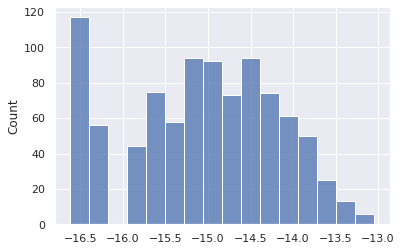

In [4]:
sns.histplot(bll_item_scores[bll_item_scores['user_id']==1006]['bll_score'])

In [38]:
itembll_all= pd.read_csv(DATA_ROOT_URL/'bll_scores_1mo.csv')
itembll_minfreq_all= pd.read_csv(DATA_ROOT_URL/'bll_scores_minfreq_1mo.csv')
data_m=itembll_all.merge(itembll_minfreq_all,on='track_id',suffixes=["","_minfreq"],how='inner')[['bll_score','bll_score_minfreq']]
print(spearmanr(data_m))


SpearmanrResult(correlation=0.47359656005243234, pvalue=0.0)


<AxesSubplot:xlabel='bll_score', ylabel='bll_score_minfreq'>

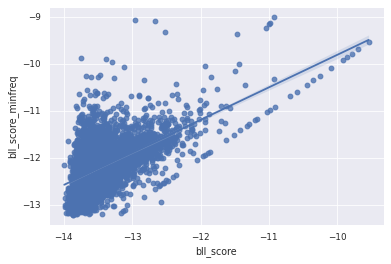

In [57]:
sns.regplot(data=data_m,x='bll_score',y='bll_score_minfreq')

SpearmanrResult(correlation=0.7415891470140522, pvalue=0.0)


<AxesSubplot:xlabel='bll_score', ylabel='bll_score_minfreq'>

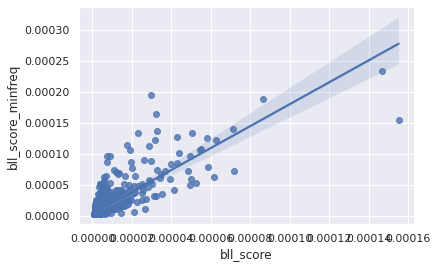

In [188]:
itembll_all= pd.read_csv(DATA_ROOT_URL/'bll_scores_1mo.csv')
itembll_minfreq_all= pd.read_csv(DATA_ROOT_URL/'bll_scores_minfreq_1mo.csv')
data_m=itembll_all.merge(itembll_minfreq_all,on='track_id',suffixes=["","_minfreq"],how='inner')[['bll_score','bll_score_minfreq']]
print(spearmanr(data_m))
sns.regplot(data=data_m,x='bll_score',y='bll_score_minfreq',)

SpearmanrResult(correlation=0.6243740867828497, pvalue=0.0)


<AxesSubplot:xlabel='bll_score', ylabel='bll_score_minfreq'>

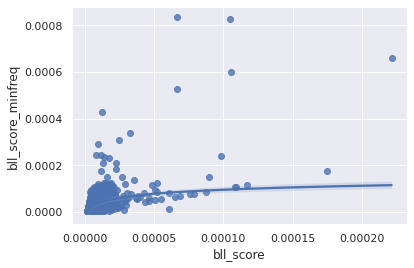

In [193]:
itembll_all= pd.read_csv(DATA_ROOT_URL/'bll_scores_1w.csv')
itembll_minfreq_all= pd.read_csv(DATA_ROOT_URL/'bll_scores_minfreq_1w.csv')
data_m=itembll_all.merge(itembll_minfreq_all,on='track_id',suffixes=["","_minfreq"],how='inner')[['bll_score','bll_score_minfreq']]
print(spearmanr(data_m))
sns.regplot(data=data_m,x='bll_score',y='bll_score_minfreq',lo)

# Calculating correlations (Onion/EMMA)

1. **Global popularity** : Relative proportion of unique listeners per track
2. **Global familiarity** : Relative proportion of users that played the track at least R>=3 and all unique listeners of that same track
3. **Average user BLL score in Timeframe**: Calculate BLL for each (user,track) pair in the timewindow='6mo' after the first appearance of the (user,track) listening event. Then group (user,track,bll_score) by track assigning the mean of the bll_scores of the group 

In [5]:
itempop_all= pd.read_csv(DATA_ROOT_URL/'track_all_popularity.csv')
itemfam_all= pd.read_csv(DATA_ROOT_URL/'track_all_familiarity.csv')
itemfam5_all= pd.read_csv(DATA_ROOT_URL/'track_all_familiarity5.csv')
itembll_all= pd.read_csv(DATA_ROOT_URL/'bll_scores_global.csv')
t_itembll_all= pd.read_csv(DATA_ROOT_URL/'bll_scores_1mo.csv')
merged_data = full_feat_tracks.merge(itempop_all,left_on='lfm_id',right_on='track_id',how='inner')
merged_data = merged_data.merge(itemfam_all,left_on='lfm_id',right_on='track_id',how='inner',suffixes=["","_3"])
merged_data = merged_data.merge(itembll_all,left_on='lfm_id',right_on='track_id',how='left',suffixes=["","_3"])
merged_data = merged_data.merge(t_itembll_all,left_on='lfm_id',right_on='track_id',how='left',suffixes=["","_t"])
merged_data.loc[merged_data['bll_score'].isna(),'bll_score']=0.0
merged_data.loc[merged_data['bll_score_t'].isna(),'bll_score_t']=0.0
gems_groups = merged_data.groupby('gem_label')

In [166]:
merged_data.drop_duplicates("lfm_id")['track_playcount'].quantile(0.999)

123046.36000000004

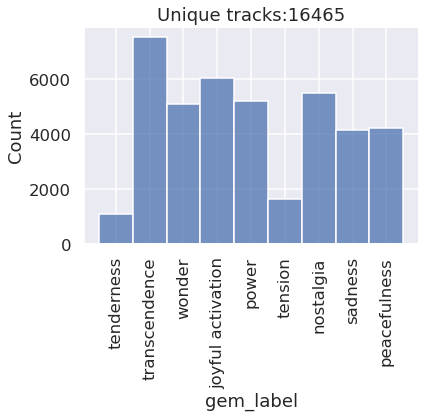

In [6]:
sns.set_context(sns.plotting_context('talk'))
sns.histplot(merged_data['gem_label'])
plt.xticks(rotation=90)
plt.title(f"Unique tracks:{merged_data['lfm_id'].nunique()}")
plt.show()

## Calculating correlations on groups of Tracks (Onion/EMMA) 

In [7]:
from collections import defaultdict
corr_all= defaultdict(lambda :list())
cols=['bll_score','bll_score_t','pop_i','fam_i']
metrics = spearmanr,#pearsonr,kendalltau,pointbiserialr
for label,tracks in gems_groups:
    #print([len(tracks),tracks['lfm_id'].nunique(),(tracks['score']>0).sum()])
    corr_all['label'].append(label)
    corr_all[f'|label|'].append(tracks['score'].count())
    for col in cols:
        for metric in metrics:
            corr_val,pval = metric(tracks['score'],tracks[col])
            corr_all[f'{col}_{metric.__name__}'].append(corr_val)
            

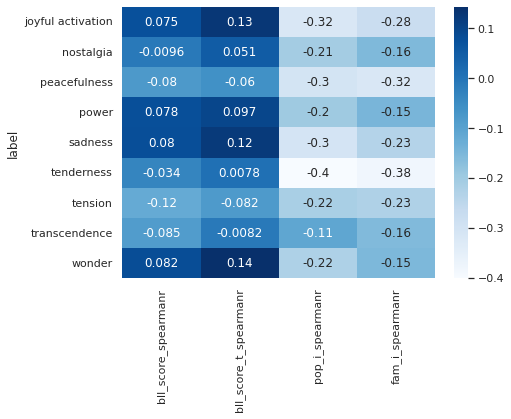

In [8]:

corr_df= pd.DataFrame(corr_all)
corr_df.set_index('label',inplace=True)
with sns.plotting_context('notebook'):
    plt.figure(figsize=(7,5))
    sns.heatmap(corr_df.iloc[:,1:], annot=True,cmap='Blues')

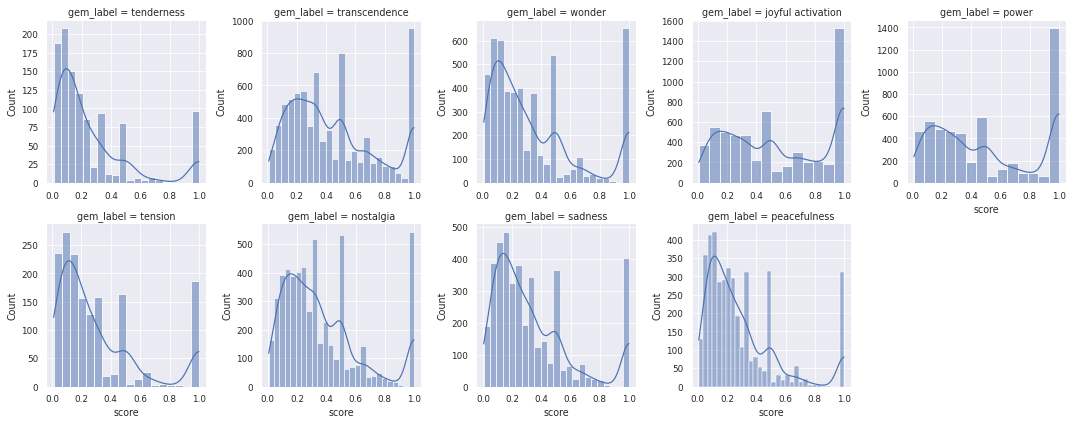

In [35]:
sns.set_context(sns.plotting_context('paper'))
g = sns.FacetGrid(merged_data,col='gem_label',col_wrap=5 ,sharey=False,sharex=False)
g = g.map(sns.histplot, 'score',kde=True)

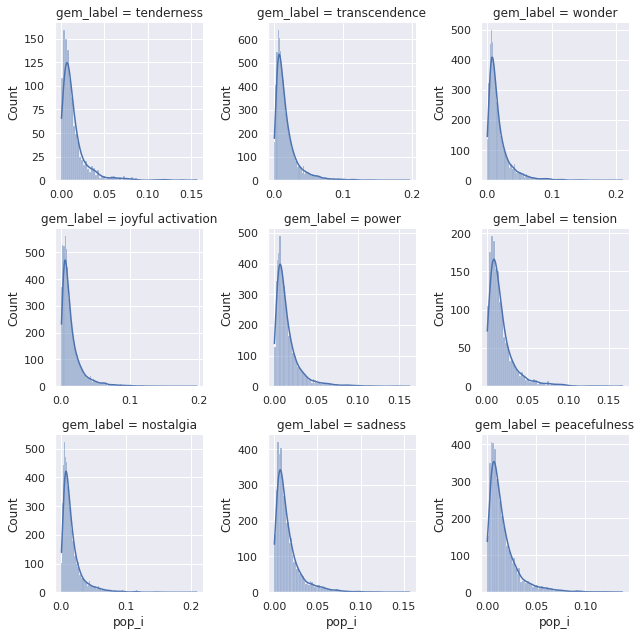

In [11]:
g = sns.FacetGrid(merged_data,col='gem_label',col_wrap=3 ,sharey=False,sharex=False)
g = g.map(sns.histplot, 'pop_i',kde=True)

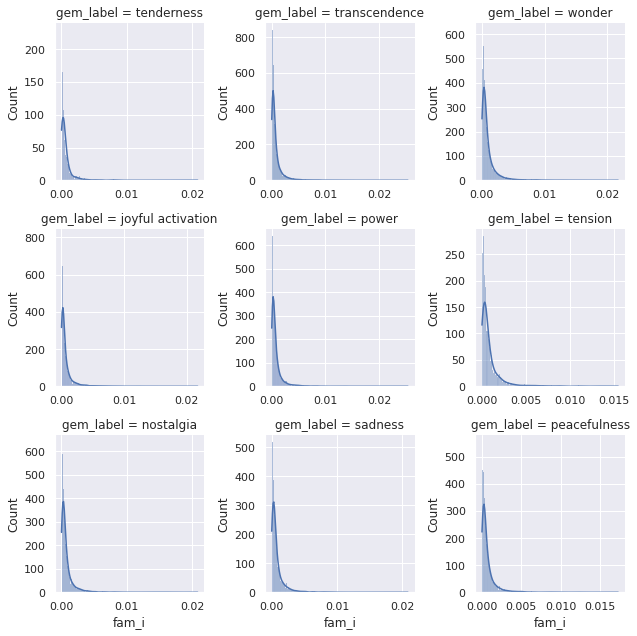

In [133]:
g = sns.FacetGrid(merged_data,col='gem_label',col_wrap=3 ,sharey=False,sharex=False)
g = g.map(sns.histplot, 'fam_i',kde=True)

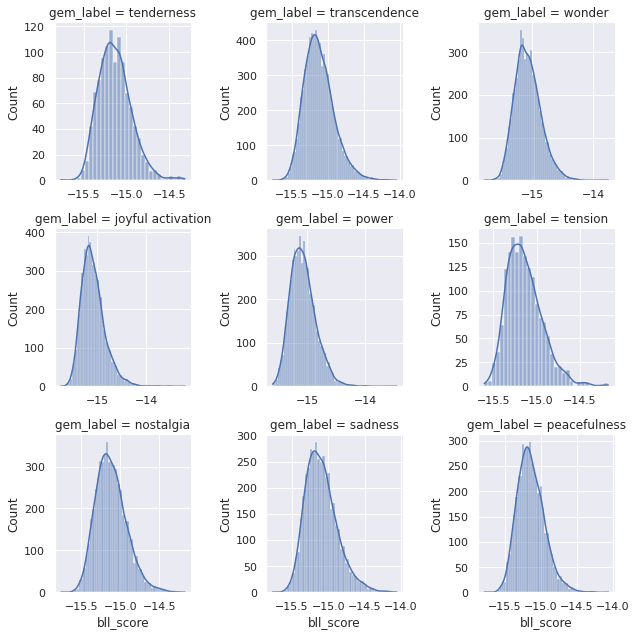

In [29]:
g = sns.FacetGrid(merged_data,col='gem_label',col_wrap=3,sharex=False,sharey=False )
g = g.map(sns.histplot, 'bll_score',kde=True)

## Calculation of correlation bewtween EMMA labels with audio features (Onion/EMMA)

In [154]:

audio_features= pd.read_csv(DATA_ROOT_URL/'emotion_audiofeatures.csv')
lfm_listening_counts= pd.read_csv(DATA_ROOT_URL/'lfm_listening_counts.csv',skiprows=1,names=['lfm_id','listening_count'])
merged_data = full_feat_tracks.merge(audio_features,left_on='lfm_id',right_on='lfm_id',how='inner').dropna(subset='valence')
itempop_all= pd.read_csv(DATA_ROOT_URL/'track_all_popularity.csv')
itemfam_all= pd.read_csv(DATA_ROOT_URL/'track_all_familiarity.csv')
merged_data = merged_data.merge(itempop_all,left_on='lfm_id',right_on='track_id',how='inner')
merged_data = merged_data.merge(itemfam_all,left_on='lfm_id',right_on='track_id',how='inner',suffixes=["","_3"])
merged_data = merged_data.merge(lfm_listening_counts,left_on='lfm_id',right_on='lfm_id',how='inner',suffixes=["","_3"])
gems_groups = merged_data.groupby('gem_label')
from collections import defaultdict
corr_all= defaultdict(lambda :list())
cols=[ 'valence', 'pop_i','fam_i','listening_count']
cols =['danceability', 'energy', 'key', 'loudness',
       'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'duration_ms', 'time_signature']
for label,tracks in gems_groups:
    #print([len(tracks),tracks['lfm_id'].nunique(),(tracks['score']>0).sum()])
    corr_all['label'].append(label)
    for col in cols:
        corr_val,pval = spearmanr(tracks[['score',col]])
        corr_all[f'{col}'].append(corr_val)
       

In [77]:
audio_features.columns

Index(['Unnamed: 0', 'lfm_id', 'danceability', 'energy', 'key', 'loudness',
       'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'type', 'duration_ms', 'time_signature'],
      dtype='object')

In [64]:
corr_df= pd.DataFrame(corr_all)
#corr_df.set_index('group',inplace=True)
cm = sns.color_palette("Blues", as_cmap=True)
s=corr_df.style.background_gradient(cmap=cm,subset=corr_df.columns[2:]).hide(axis='index')
print(s.to_latex(
    hrules=True,
    clines='skip-last;index',
   caption='table',
    position_float='centering',
    multicol_align='l',
    convert_css=True,
    ))

\begin{table}
\centering
\caption{table}
\begin{tabular}{lrrrrr}
\toprule
label & |label| & bll_score_spearmanr & bll_score_t_spearmanr & pop_i_spearmanr & fam_i_spearmanr \\
\midrule
joyful activation & 6048 & {\cellcolor[HTML]{083877}} \color[HTML]{F1F1F1} 0.075245 & {\cellcolor[HTML]{084285}} \color[HTML]{F1F1F1} 0.128098 & {\cellcolor[HTML]{BCD7EB}} \color[HTML]{000000} -0.318430 & {\cellcolor[HTML]{81BADB}} \color[HTML]{000000} -0.275565 \\
nostalgia & 5500 & {\cellcolor[HTML]{5CA4D0}} \color[HTML]{F1F1F1} -0.009590 & {\cellcolor[HTML]{4D99CA}} \color[HTML]{F1F1F1} 0.050950 & {\cellcolor[HTML]{3686C0}} \color[HTML]{F1F1F1} -0.205993 & {\cellcolor[HTML]{083979}} \color[HTML]{F1F1F1} -0.155057 \\
peacefulness & 4213 & {\cellcolor[HTML]{D0E2F2}} \color[HTML]{000000} -0.079751 & {\cellcolor[HTML]{E4EFF9}} \color[HTML]{000000} -0.060058 & {\cellcolor[HTML]{AACFE5}} \color[HTML]{000000} -0.302366 & {\cellcolor[HTML]{C1D9ED}} \color[HTML]{000000} -0.318322 \\
power & 5186 & {\cellcolor[H

In [65]:
s

label,|label|,bll_score_spearmanr,bll_score_t_spearmanr,pop_i_spearmanr,fam_i_spearmanr
joyful activation,6048,0.075245,0.128098,-0.318430,-0.275565
nostalgia,5500,-0.009590,0.050950,-0.205993,-0.155057
peacefulness,4213,-0.079751,-0.060058,-0.302366,-0.318322
power,5186,0.078442,0.096591,-0.197560,-0.146316
sadness,4145,0.079992,0.120992,-0.304626,-0.233491
tenderness,1094,-0.033812,0.007809,-0.401435,-0.380841
tension,1634,-0.119219,-0.081831,-0.215145,-0.225801
transcendence,7533,-0.084750,-0.008241,-0.109878,-0.158099
wonder,5083,0.081859,0.143053,-0.224417,-0.153118


## Calculating correlations on binarized EMMA labels (Onion/EMMA)

In [18]:
audio_features= pd.read_csv(DATA_ROOT_URL/'emotion_audiofeatures.csv')
lfm_listening_counts= pd.read_csv(DATA_ROOT_URL/'lfm_listening_counts.csv',skiprows=1,names=['lfm_id','listening_count'])
merged_data = full_feat_tracks.merge(audio_features,left_on='lfm_id',right_on='lfm_id',how='inner').dropna(subset='valence')
itempop_all= pd.read_csv(DATA_ROOT_URL/'track_all_popularity.csv')
itemfam_all= pd.read_csv(DATA_ROOT_URL/'track_all_familiarity.csv')
merged_data = merged_data.merge(itempop_all,left_on='lfm_id',right_on='track_id',how='inner')
merged_data = merged_data.merge(itemfam_all,left_on='lfm_id',right_on='track_id',how='inner',suffixes=["","_3"])
merged_data = merged_data.merge(lfm_listening_counts,left_on='lfm_id',right_on='lfm_id',how='inner',suffixes=["","_3"])
gems_groups = merged_data.groupby('gem_label')

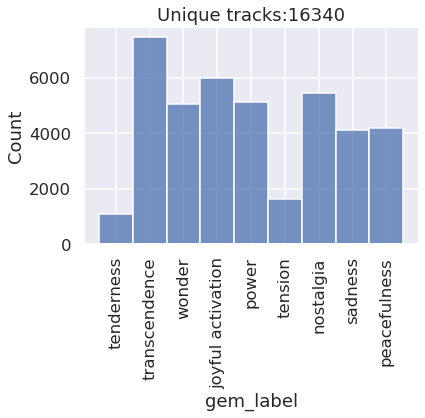

In [19]:
sns.set_context(sns.plotting_context('talk'))
sns.histplot(merged_data['gem_label'])
plt.xticks(rotation=90)
plt.title(f"Unique tracks:{merged_data['lfm_id'].nunique()}")
plt.show()

In [20]:
merged_data = merged_data.drop_duplicates(['lfm_id']).merge(merged_data.pivot(columns='gem_label', index='lfm_id', values='score'), left_on='lfm_id',right_index=True,how='inner')

In [21]:
from collections import defaultdict
corr_all= defaultdict(lambda :list())
cols=[ 'valence', 'pop_i','fam_i','listening_count']
cols =['danceability', 'energy', 'key', 'loudness',
       'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'duration_ms', 'time_signature']
for label,tracks in gems_groups:
    #print([len(tracks),tracks['lfm_id'].nunique(),(tracks['score']>0).sum()])
    corr_all['label'].append(label)
    for col in cols:
        corr_val,pval = spearmanr(tracks[['score',col]])
        corr_all[f'{col}'].append(corr_val)
       

In [22]:
from collections import defaultdict
corr_all= defaultdict(lambda :list())

cols_e =merged_data.columns[-9:]
cols_p =['pop_i','fam_i']
for e in cols_e:
    corr_all['label'].append(e)
    for p in cols_p:
        corr_val,pval = pointbiserialr(merged_data[p],merged_data[e].notna())
        corr_all[f'{p}'].append(corr_val)
       

<AxesSubplot:ylabel='label'>

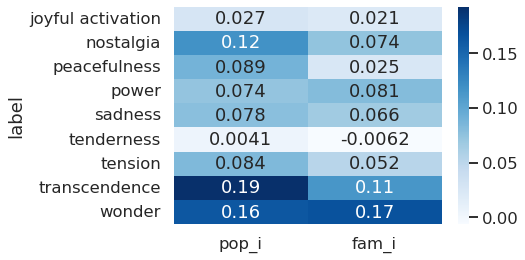

In [24]:
corr_df= pd.DataFrame(corr_all)
corr_df.set_index('label',inplace=True)
sns.heatmap(corr_df, annot=True,cmap='Blues')

# Calculating correlations on EMMA tracks

In [17]:
emma_database_merged=pd.read_csv(DATA_ROOT_URL/'emma_database_merge.csv')
itembll_all= pd.read_csv(DATA_ROOT_URL/'bll_scores_global.csv')
merged_data = emma_database_merged.merge(itempop_all,left_on='lfm_id',right_on='track_id',how='inner')
merged_data = merged_data.merge(itemfam_all,left_on='lfm_id',right_on='track_id',how='inner',suffixes=["","_3"])
merged_data = merged_data.merge(itembll_all,left_on='lfm_id',right_on='track_id',how='left',suffixes=["","_3"])
merged_data.loc[merged_data['bll_score'].isna(),'bll_score']=0.0
corr,pval = spearmanr(merged_data[['Wonder', 'Transcendence', 'Nostalgia', 'Tenderness',
       'Peacfulness', 'Joy', 'Power', 'Tension', 'Sadness', 'Sublimity',
       'Vitality', 'Unease', 'ICC', 'Familiarity', 'Liking','pop_i','fam_i','bll_score']])

<AxesSubplot:title={'center':'Matching tracks Music4All-Emma :43'}>

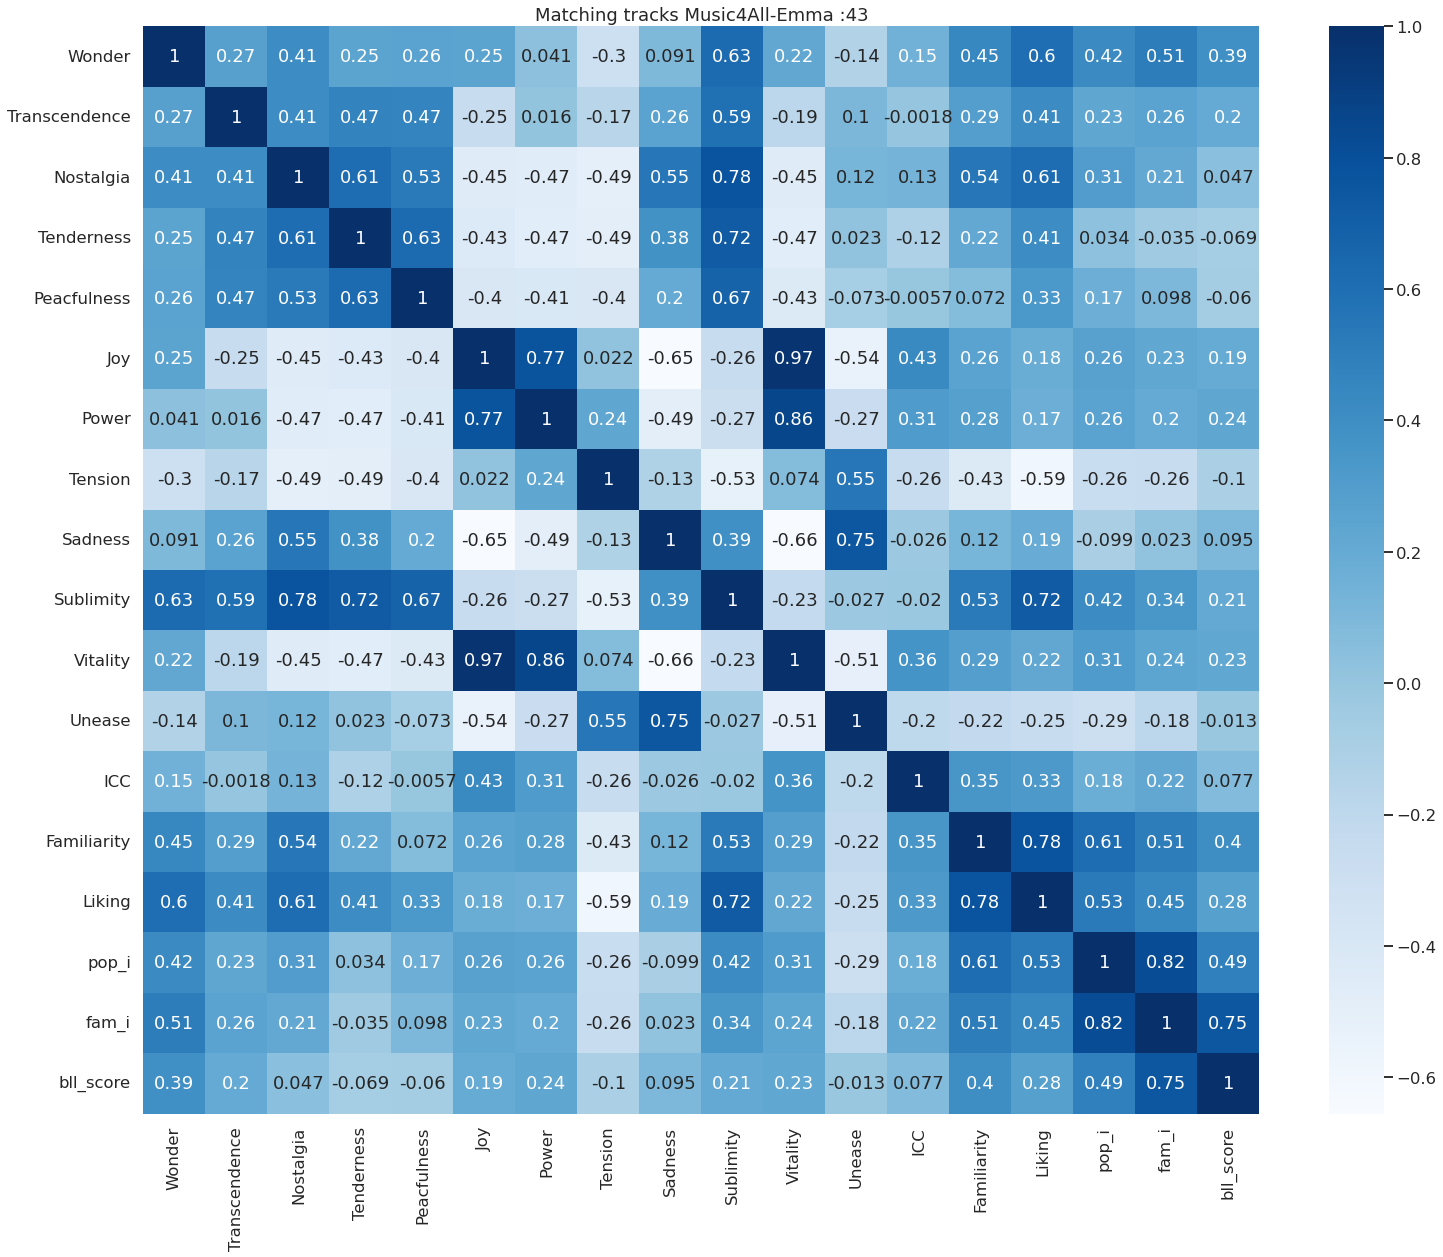

In [18]:
plt.figure(figsize=(25,20))
plt.title(f"Matching tracks Music4All-Emma :{len(merged_data)}")
sns.heatmap(merged_data[['Wonder', 'Transcendence', 'Nostalgia', 'Tenderness',
       'Peacfulness', 'Joy', 'Power', 'Tension', 'Sadness', 'Sublimity',
       'Vitality', 'Unease', 'ICC', 'Familiarity', 'Liking','pop_i','fam_i','bll_score']].corr(),annot=True,cmap='Blues')

<AxesSubplot:ylabel='Frequency'>

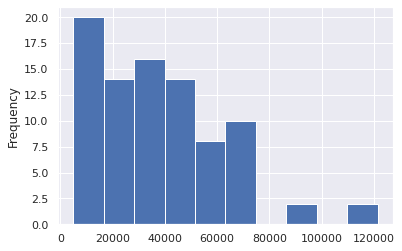

In [153]:
merged_data['track_playcount'].plot.hist()

<AxesSubplot:ylabel='Frequency'>

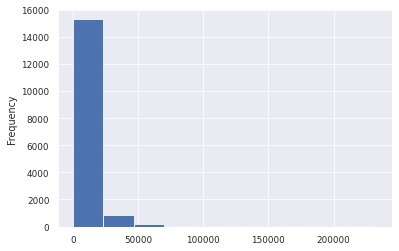

In [67]:
merged_data.drop_duplicates('lfm_id')['track_playcount'].plot.hist()

In [42]:
merged_data.columns

Index(['row_id', 'gem_label', 'score', 'id', '(tag, weight)', 'gems',
       'gems_profile', 'genre', 'microgenre', 'lfm_id', 'date', 'date_prec',
       'year', 'month', 'day', 'release_date', 'track_id', 'pop_i',
       'track_playcount', 'track_id_3', 'num_fam_users', 'fam_i', 'track_id_3',
       'bll_score'],
      dtype='object')

In [108]:
full_feat_tracksv2=pd.read_csv(DATA_ROOT_URL/'v2_emotions_familiarity_full_feat_stack.tsv',sep='\t')
full_feat_tracksv1=pd.read_csv(DATA_ROOT_URL/'emotions_familiarity_full_feat_stack.tsv',sep='\t')

In [109]:
full_feat_tracksv1.set_index(['id','gem_label'],inplace=True)
full_feat_tracksv2.set_index(['id','gem_label'],inplace=True)


In [35]:
concatenated =pd.concat([full_feat_tracksv1,full_feat_tracksv2],axis=1,join='inner')#[['id','gem_label_norm','score_norm','gem_label','score']]

In [36]:
concatenated.columns

Index(['row_id', 'score', '(tag, weight)', 'gems', 'gems_profile', 'genre',
       'microgenre', 'lfm_id', 'date', 'date_prec', 'year', 'month', 'day',
       'release_date', 'row_id', 'score', 'track_uri', 'date', 'date_prec',
       'gems', 'gems_profile', 'gems_profile_no_rescaling', 'genre',
       'microgenre', 'lfm_id', 'year', 'month', 'day', 'release_date'],
      dtype='object')

In [38]:
values=concatenated['score']

In [43]:
values.columns =['score_norm', 'score']

In [45]:
values.reset_index().dropna().to_csv(DATA_ROOT_URL/'norm_vs_notnorm_gems.csv',index=False)

In [60]:
values = pd.read_csv(DATA_ROOT_URL/'norm_vs_notnorm_gems.csv')


,id,gem_label,score_norm,score,Unnamed: 0,artist,title,Wonder,Transcendence,Nostalgia,...,lfm_id,power,tenderness,transcendence,wonder,joyful activation,tension,nostalgia,sadness,peacefulness
0,007LIJOPQ4Sb98qV,tenderness,1.000000,7.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,00CH4HJdxQQQbJfu,transcendence,1.000000,70.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,00P2bHdWFkghmDqz,wonder,0.500000,8.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,00P2bHdWFkghmDqz,joyful activation,0.500000,8.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,00mLjKFmaTv9MdaB,power,0.025424,3.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40394,zzx8CWdM7qkxKQpC,power,0.233333,7.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
40395,zzx8CWdM7qkxKQpC,wonder,0.366667,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
40396,zzx8CWdM7qkxKQpC,joyful activation,0.266667,8.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
40397,zzx8CWdM7qkxKQpC,sadness,0.133333,4.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [104]:
merged  = values.merge(emma_database_merged,left_on='id',right_on='_id',how='inner',suffixes=["","_emma"])

In [107]:

merged.drop_duplicates(subset=['id','gem_label'])

,id,gem_label,score_norm,score,Unnamed: 0,artist,title,Wonder,Transcendence,Nostalgia,...,lfm_id,power,tenderness,transcendence,wonder,joyful activation,tension,nostalgia,sadness,peacefulness
0,6sUE7Mf0a49mHeJr,transcendence,0.888889,16.0,8,2Pac,Keep Ya Head Up,4.90,6.02,5.52,...,2624,0.0,0.0,0.888889,0.0,0.000000,0.0,0.000000,0.111111,0.000000
1,6sUE7Mf0a49mHeJr,sadness,0.111111,2.0,8,2Pac,Keep Ya Head Up,4.90,6.02,5.52,...,2624,0.0,0.0,0.888889,0.0,0.000000,0.0,0.000000,0.111111,0.000000
2,ABwvIfsLLaa97kJp,transcendence,0.500000,31.0,16,Mattafix,Big City Life,17.52,10.71,15.30,...,3950,0.0,0.0,0.500000,0.0,0.161290,0.0,0.306452,0.000000,0.032258
3,ABwvIfsLLaa97kJp,joyful activation,0.161290,10.0,16,Mattafix,Big City Life,17.52,10.71,15.30,...,3950,0.0,0.0,0.500000,0.0,0.161290,0.0,0.306452,0.000000,0.032258
4,ABwvIfsLLaa97kJp,nostalgia,0.306452,19.0,16,Mattafix,Big City Life,17.52,10.71,15.30,...,3950,0.0,0.0,0.500000,0.0,0.161290,0.0,0.306452,0.000000,0.032258
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,zbI3TrMSY2chqzRz,transcendence,0.633333,38.0,32,Dido,White Flag,6.26,11.51,25.95,...,24240,0.0,0.0,0.633333,0.0,0.016667,0.0,0.100000,0.083333,0.166667
72,zbI3TrMSY2chqzRz,joyful activation,0.016667,1.0,32,Dido,White Flag,6.26,11.51,25.95,...,24240,0.0,0.0,0.633333,0.0,0.016667,0.0,0.100000,0.083333,0.166667
73,zbI3TrMSY2chqzRz,nostalgia,0.100000,6.0,32,Dido,White Flag,6.26,11.51,25.95,...,24240,0.0,0.0,0.633333,0.0,0.016667,0.0,0.100000,0.083333,0.166667
74,zbI3TrMSY2chqzRz,sadness,0.083333,5.0,32,Dido,White Flag,6.26,11.51,25.95,...,24240,0.0,0.0,0.633333,0.0,0.016667,0.0,0.100000,0.083333,0.166667


In [68]:
a=sorted( ['Wonder', 'Transcendence', 'Nostalgia', 'Tenderness',
       'Peacfulness', 'Joy', 'Power', 'Tension', 'Sadness'])

b=sorted(['power', 'tenderness',
       'transcendence', 'wonder', 'joyful activation', 'tension', 'nostalgia',
       'sadness', 'peacefulness'])
lfm2emma= {k:v for k,v in zip(b,a)}

In [81]:

merged['emma']=[merged.loc[row[0],lfm2emma.get(row[1]['gem_label'])] for row in  merged.iterrows()]

In [83]:
merged.columns

Index(['id', 'gem_label', 'score_norm', 'score', 'Unnamed: 0', 'artist',
       'title', 'Wonder', 'Transcendence', 'Nostalgia', 'Tenderness',
       'Peacfulness', 'Joy', 'Power', 'Tension', 'Sadness', 'Sublimity',
       'Vitality', 'Unease', 'ICC', 'Familiarity', 'Liking', '_id', 'track',
       'album', 'lfm', 'spotify', 'id_emma', '(tag, weight)', 'gems',
       'gems_profile', 'genre', 'microgenre', 'lfm_id', 'power', 'tenderness',
       'transcendence', 'wonder', 'joyful activation', 'tension', 'nostalgia',
       'sadness', 'peacefulness', 'emma'],
      dtype='object')

In [87]:
merged[['id', 'gem_label', 'score_norm', 'score','emma']].to_csv(DATA_ROOT_URL/'lfm_norm_lfm_emma.csv',index=False)

In [89]:
merged[['id', 'gem_label', 'score_norm', 'score','emma']]

,id,gem_label,score_norm,score,emma
4521,6sUE7Mf0a49mHeJr,transcendence,0.888889,16.0,6.02
4522,6sUE7Mf0a49mHeJr,sadness,0.111111,2.0,3.12
6776,ABwvIfsLLaa97kJp,transcendence,0.500000,31.0,10.71
6777,ABwvIfsLLaa97kJp,joyful activation,0.161290,10.0,23.90
6778,ABwvIfsLLaa97kJp,nostalgia,0.306452,19.0,15.30
...,...,...,...,...,...
40083,zbI3TrMSY2chqzRz,transcendence,0.633333,38.0,11.51
40084,zbI3TrMSY2chqzRz,joyful activation,0.016667,1.0,11.01
40085,zbI3TrMSY2chqzRz,nostalgia,0.100000,6.0,25.95
40086,zbI3TrMSY2chqzRz,sadness,0.083333,5.0,5.92


In [92]:
full_feat_tracksv2.isna().sum()

row_id                       0
score                        0
track_uri                    0
date                         0
date_prec                    0
gems                         0
gems_profile                 0
gems_profile_no_rescaling    0
genre                        0
microgenre                   0
lfm_id                       0
year                         0
month                        0
day                          0
release_date                 0
dtype: int64

In [99]:
np.intersect1d(full_feat_tracksv1.index.get_level_values(0).unique(),full_feat_tracksv2.index.get_level_values(0).unique()).shape

(16435,)

VAE: can fit sequentiality by buckets 
KNN: pointwise 
GRU4Rec: Seq-RL chose 1 item